## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.iolib.table import SimpleTable

## Read dataset

In [3]:
dataset = pd.read_csv("input/DailyDelhiClimateTrain.csv", index_col='date', dayfirst=True)
df = pd.DataFrame(dataset)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
#hum = dataset.humidity
#hum.head()


## ACF & PACF for 0-diff

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


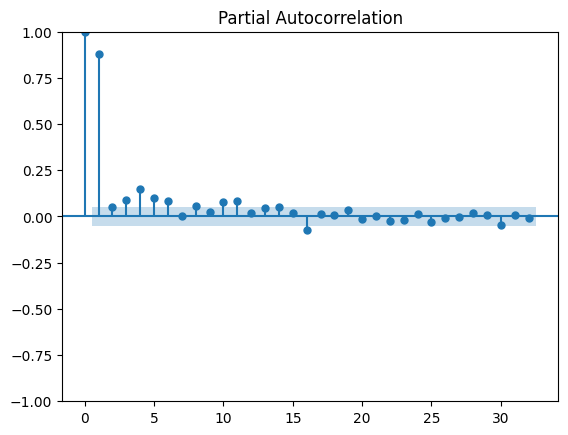

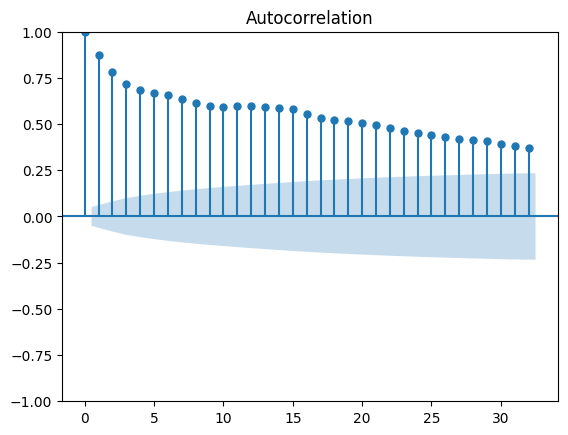

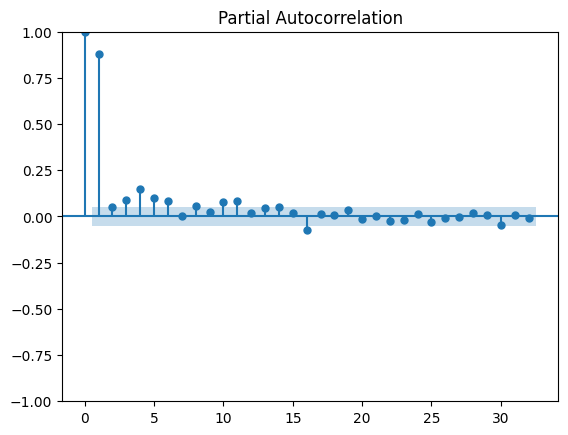

In [5]:
plot_acf(dataset.humidity)
plot_pacf(dataset.humidity)

## ACF & PACF for 1-diff

In [14]:
hum_diff = dataset.humidity.diff().iloc[1:]

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


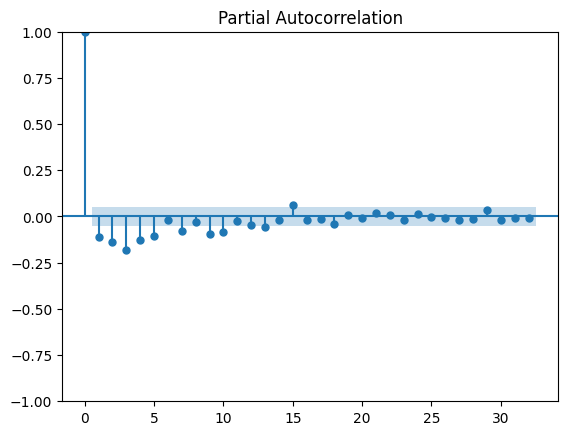

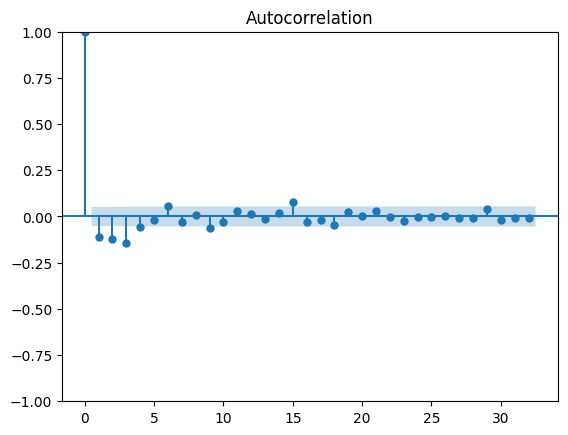

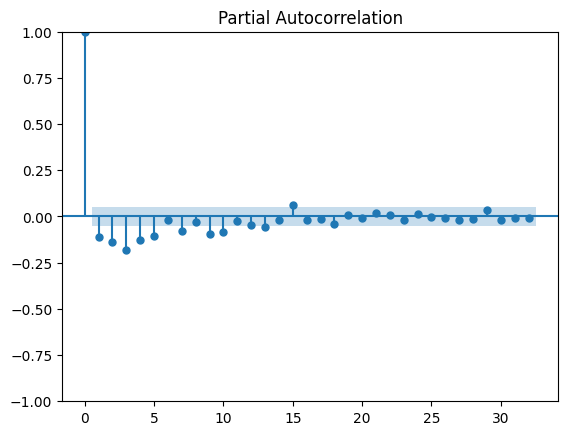

In [15]:
plot_acf(hum_diff)
plot_pacf(hum_diff)

## Plot

<Axes: xlabel='date'>

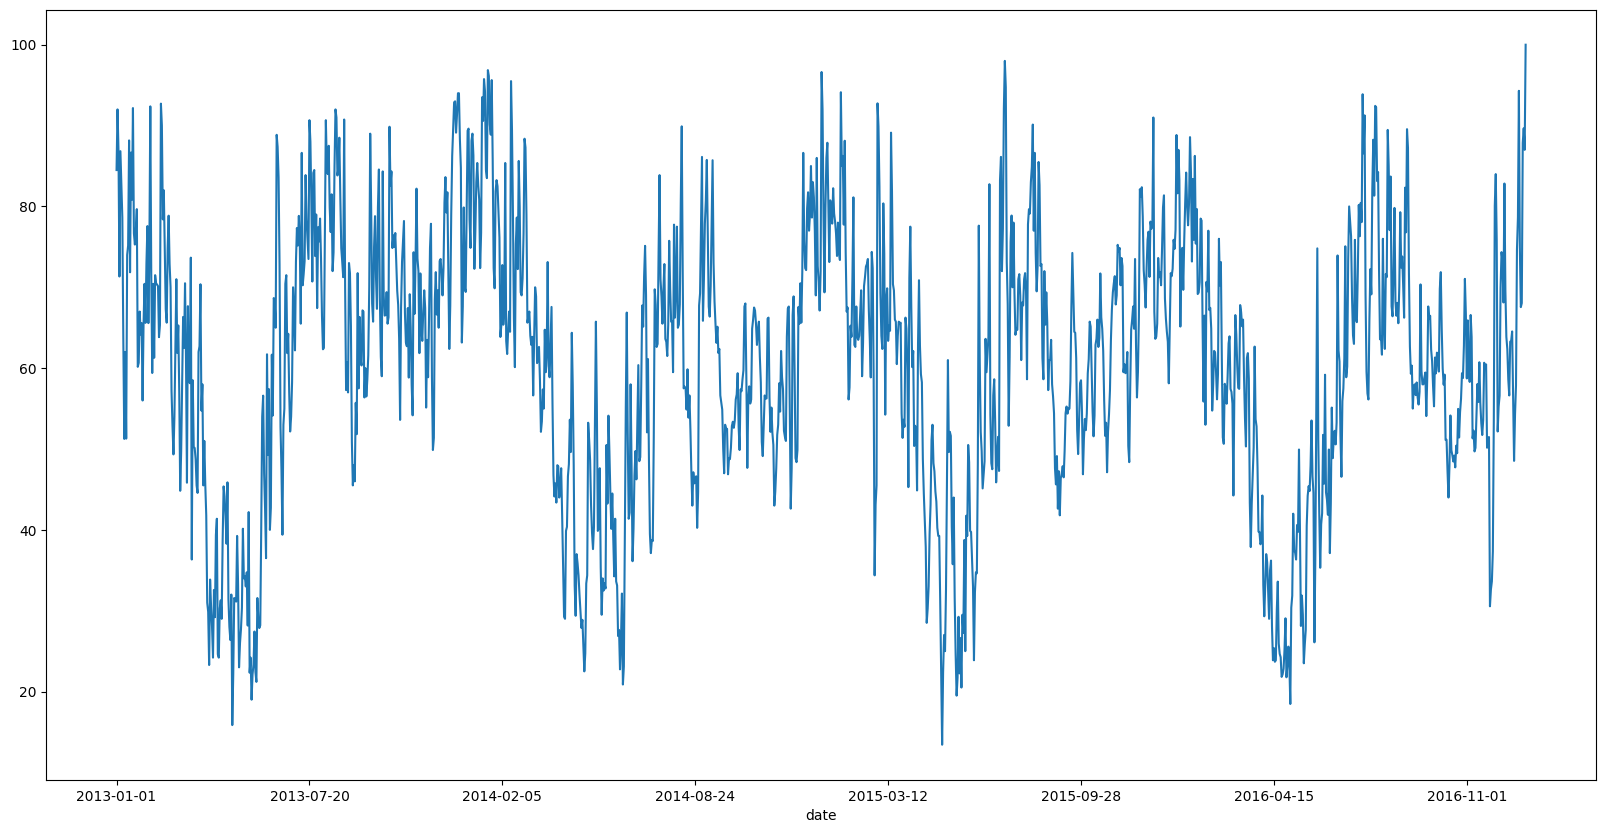

In [16]:
dataset.humidity.plot(figsize=(20,10))

## Set options

In [17]:
df_test = pd.read_csv("input/DailyDelhiClimateTrain.csv")

In [18]:
row = df_test["humidity"]
training_time_steps = 1000

## Training

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(row[:training_time_steps], order=(1, 1, 1), seasonal_order=(1,1,1,60))
fitted = model.fit()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

KeyboardInterrupt



## Get series

In [20]:
fc = fitted.get_forecast(len(row[training_time_steps:]))
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=row[training_time_steps:].index)
lower_series = pd.Series(conf.iloc[:, 0], index=row[training_time_steps:].index)
upper_series = pd.Series(conf.iloc[:, 1], index=row[training_time_steps:].index)

NameError: name 'fitted' is not defined

## Plot

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


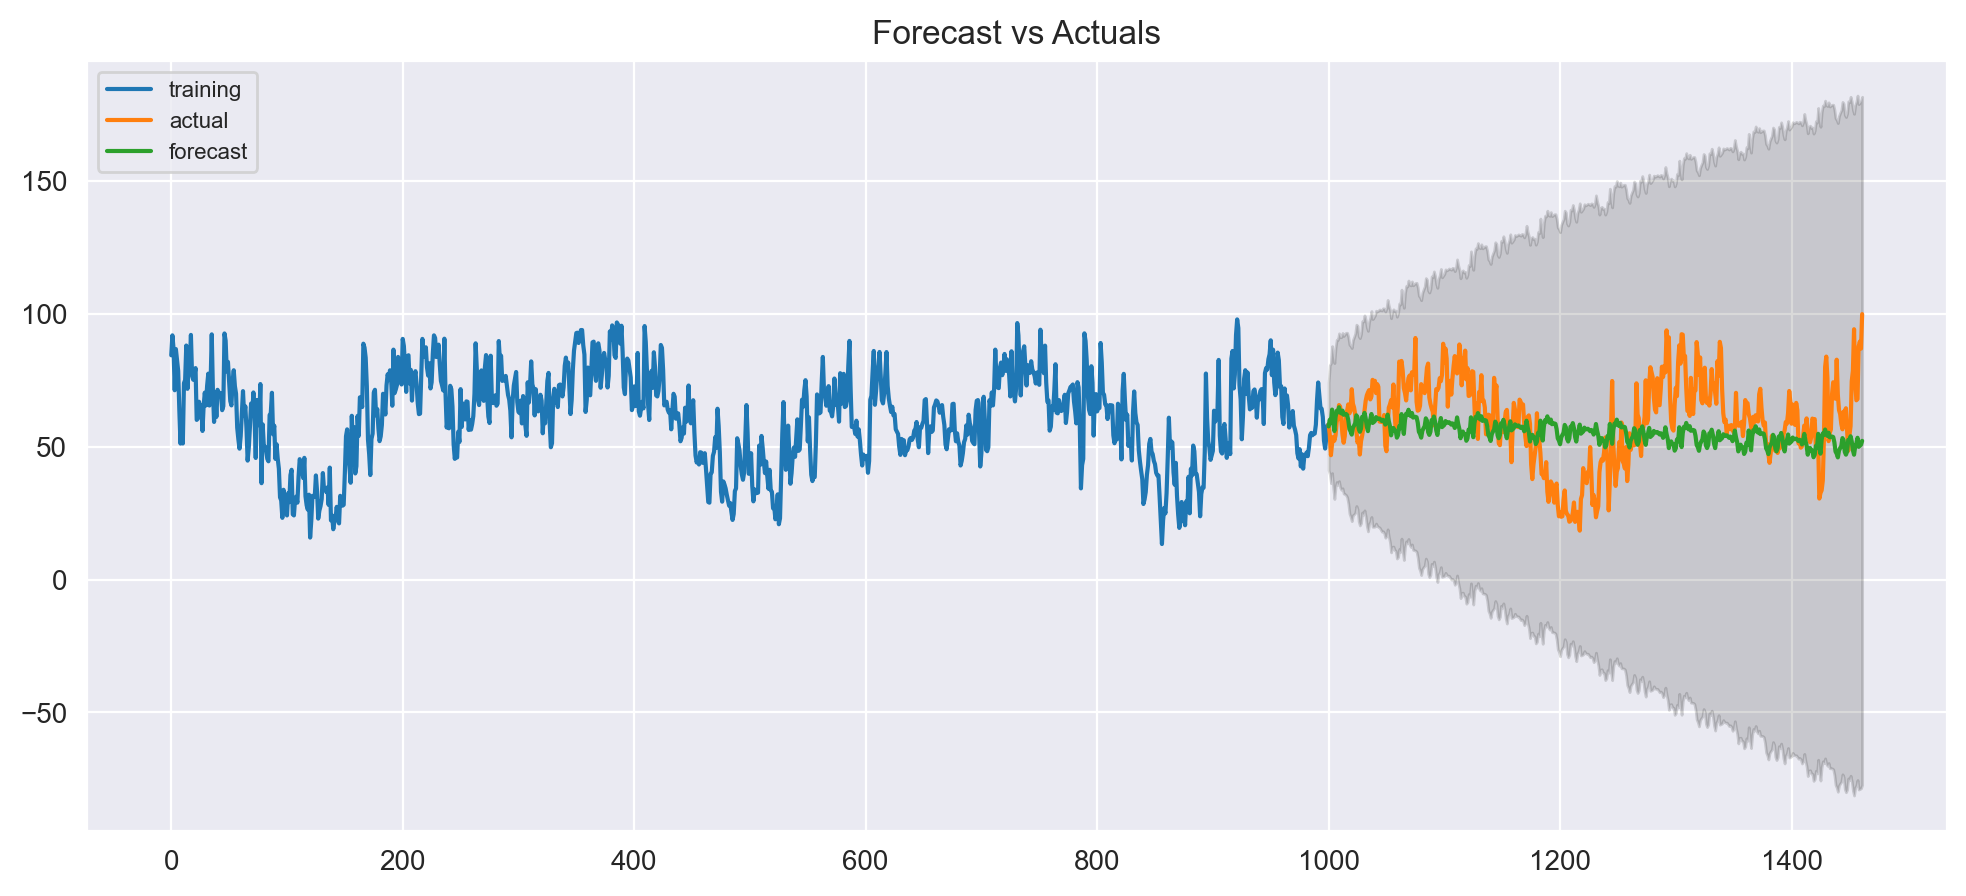

In [14]:
plt.figure(figsize=(12,5), dpi=200)
plt.plot(row[:training_time_steps], label='training')
plt.plot(row[training_time_steps:], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# LSTM

In [15]:
sequence_length = 30
X = []
y = []
time_steps = len(row)
for i in range(time_steps - sequence_length):
    sequence = row[i:(i+sequence_length)]
    X.append(sequence)
    y.append(row[i+sequence_length])
X = np.array(X)
y = np.array(y)

In [16]:
import math
time_steps = len(X)
training_time_steps = math.floor(time_steps * 0.7)
X_train = X[:training_time_steps]
X_test = X[training_time_steps:]
y_train = y[:training_time_steps]
y_test = y[training_time_steps:]

X_train_sequences = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_sequences = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_anth = X.reshape(X.shape[0], 1, X.shape[1])

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses, metrics, optimizers

regressor = Sequential([layers.LSTM(units = 32, activation = 'relu', input_shape = (1, sequence_length)), layers.Dense(1)])

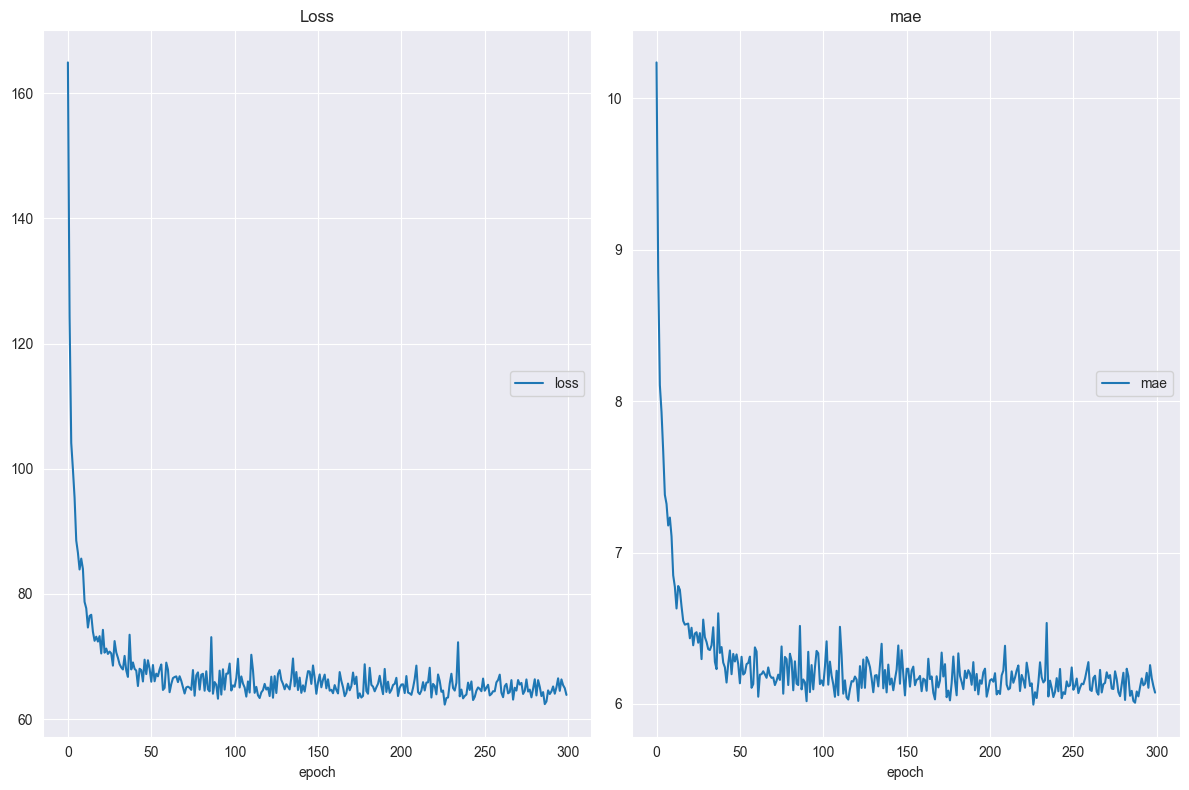

Loss
	loss             	 (min:   62.319, max:  164.917, cur:   63.869)
mae
	mae              	 (min:    5.996, max:   10.236, cur:    6.075)


In [18]:
from livelossplot import PlotLossesKerasTF
regressor.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
history = regressor.fit(X_train_sequences, y_train, batch_size=10, epochs=300, verbose=0, callbacks=[PlotLossesKerasTF()])

In [19]:
y_predicted = regressor.predict(X_test_sequences)

14/14 [==============================] - 0s 0s/step


In [20]:
training_sequences = training_time_steps

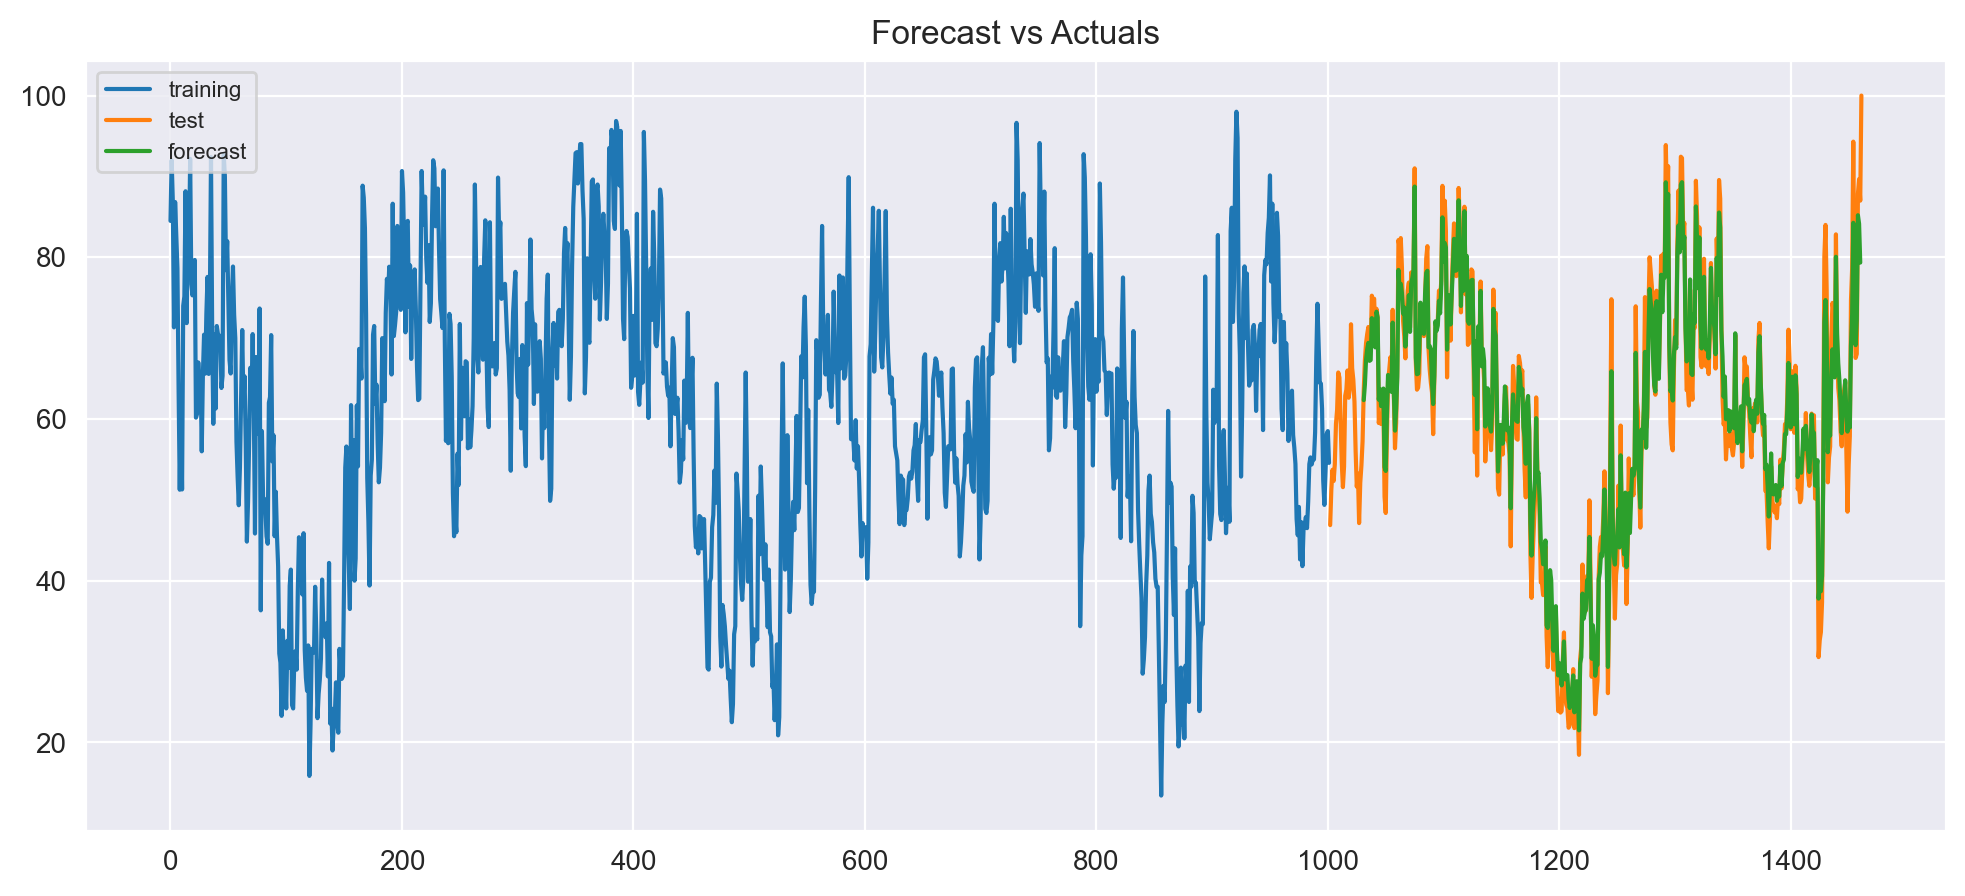

In [21]:
plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(training_sequences), row[:training_sequences], label='training')
plt.plot(range(training_sequences, len(row)), row[training_sequences:], label='test')
plt.plot(range(1031,1461), y_predicted, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()